In [1]:
# Loading in libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path
import os
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import similaritymeasures
#from smt.sampling_methods import LHS
# Importing helper libraries for bayesian optimization
from dependencies.data_preprocessing_class import dataPreprocessing
from dependencies.gaussian_process_regression_class import gaussianProcessRegression
from dependencies.acquisition_functions_class import acqisitionFunctions
from dependencies.geometry_writer import geometryWriter
from dependencies.feature_extractor_4 import FeatureExtractor

## 1. Preparing data

7 parameters defining the edge length ($Lo^{col}_{A}$, $Lo^{col}_{B}$, $Lo^{col}_{L}$) and contractility ($k^{col}_{A}$, $k^{col}_{B}$, $k^{col}_{L}$) of columnar cells along with ECM strength ($K_{ECM}$) were perturbed individually and pairwise by 70%. 

1. Structure of frechet error arrays for calculating non diagonal elements of Hessian matrix
    - The first 'for' loop iterates over all the parameters and within the main loop is another embedded 'for' loop startes just ahead of the parameter within loop 1.
    - For and parameter compination $P_{1}$ and $P_{2}$ apical and basal frechet errors for the following parameter combinations are evaluated in order (i) $P_{1}+0.7P_{1}$, $P_{2}+0.7P_{2}$ (ii) $P_{1}-0.7P_{1}$, $P_{2}-0.7P_{2}$ (iii) $P_{1}+0.7P_{1}$, $P_{2}-0.7P_{2}$ (iv) $P_{1}-0.7P_{1}$, $P_{2}+0.7P_{2}$.


2. Structure of frechet error arrays for calculating non diagonal elements of Hessian matrix
    - For each parameter it was varied 70 percent more and less that the value for the equilibrium shape of disc. 
    

In [2]:
# Loading frechet error for parameter bounds for approximating hessian of non diagonal element
error_target_sampled_apical = np.load('output_data_files\error_target_sampled_apical.npy')
error_target_sampled_basal = np.load('output_data_files\error_target_sampled_basal.npy')

# Loading frechet error for parameter bounds for approximating hessian of diagonal element
error_apical_one_d = np.load('output_data_files\error_apical_one_d.npy')
error_basal_one_d = np.load('output_data_files\error_basal_one_d.npy')

## 2.  Calculating hessian matrix of frechet errors using finite differences

Following formulaes were used for calculation of Frechet errors. Diagonal and non diagonal elements were evaluated separately

1. Calcaulation of non-diagonal elements 
    - $H_{ij} = \frac{F_{\theta_{i} + \Delta\theta_{i}, \theta_{j} + \Delta\theta_{j}} - F_{\theta_{i} - \Delta\theta_{i}, \theta_{j} + \Delta\theta_{j}} - F_{\theta_{i} + \Delta\theta_{i}, \theta_{j} - \Delta\theta_{j}} + F_{\theta_{i} - \Delta\theta_{i}, \theta_{j} - \Delta\theta_{j}}}{4\Delta\theta_{i}\Delta\theta_{j}} $, where H is the Hessian, F denotes the Frechet error and $\theta$ denotes the parameter value.


2. Hessian matrix is symmetric
    - $H_{ji} = H_{ij}$


3. Calculation of non diagonal elements
    - $H_{ii} = \frac{F_{\theta_{i} + \Delta\theta_{i}} - 2F_{\theta_{i}} + F_{\theta_{i} - \Delta\theta_{i}}}{\Delta\theta_{i}^{2}} $
    - $F_{\theta_{i}} = 0$
    

5. Two different methods are used for calculating hessians.
    - calc_method == 1: Relative change in parameter values are calculated as exact change in parameter values (0.7$P_{i}$).
    - calc_method == 2: Relative change in parameter values are calculated as percentage change in parameters (0.7)
    
    
6. Hessian matrices are plooed for apical and basal frechet errors as a heatmap


Text(0.5,1,'$d^{2}F_{B}/d\\Theta_{i}d\\Theta_{j}$')

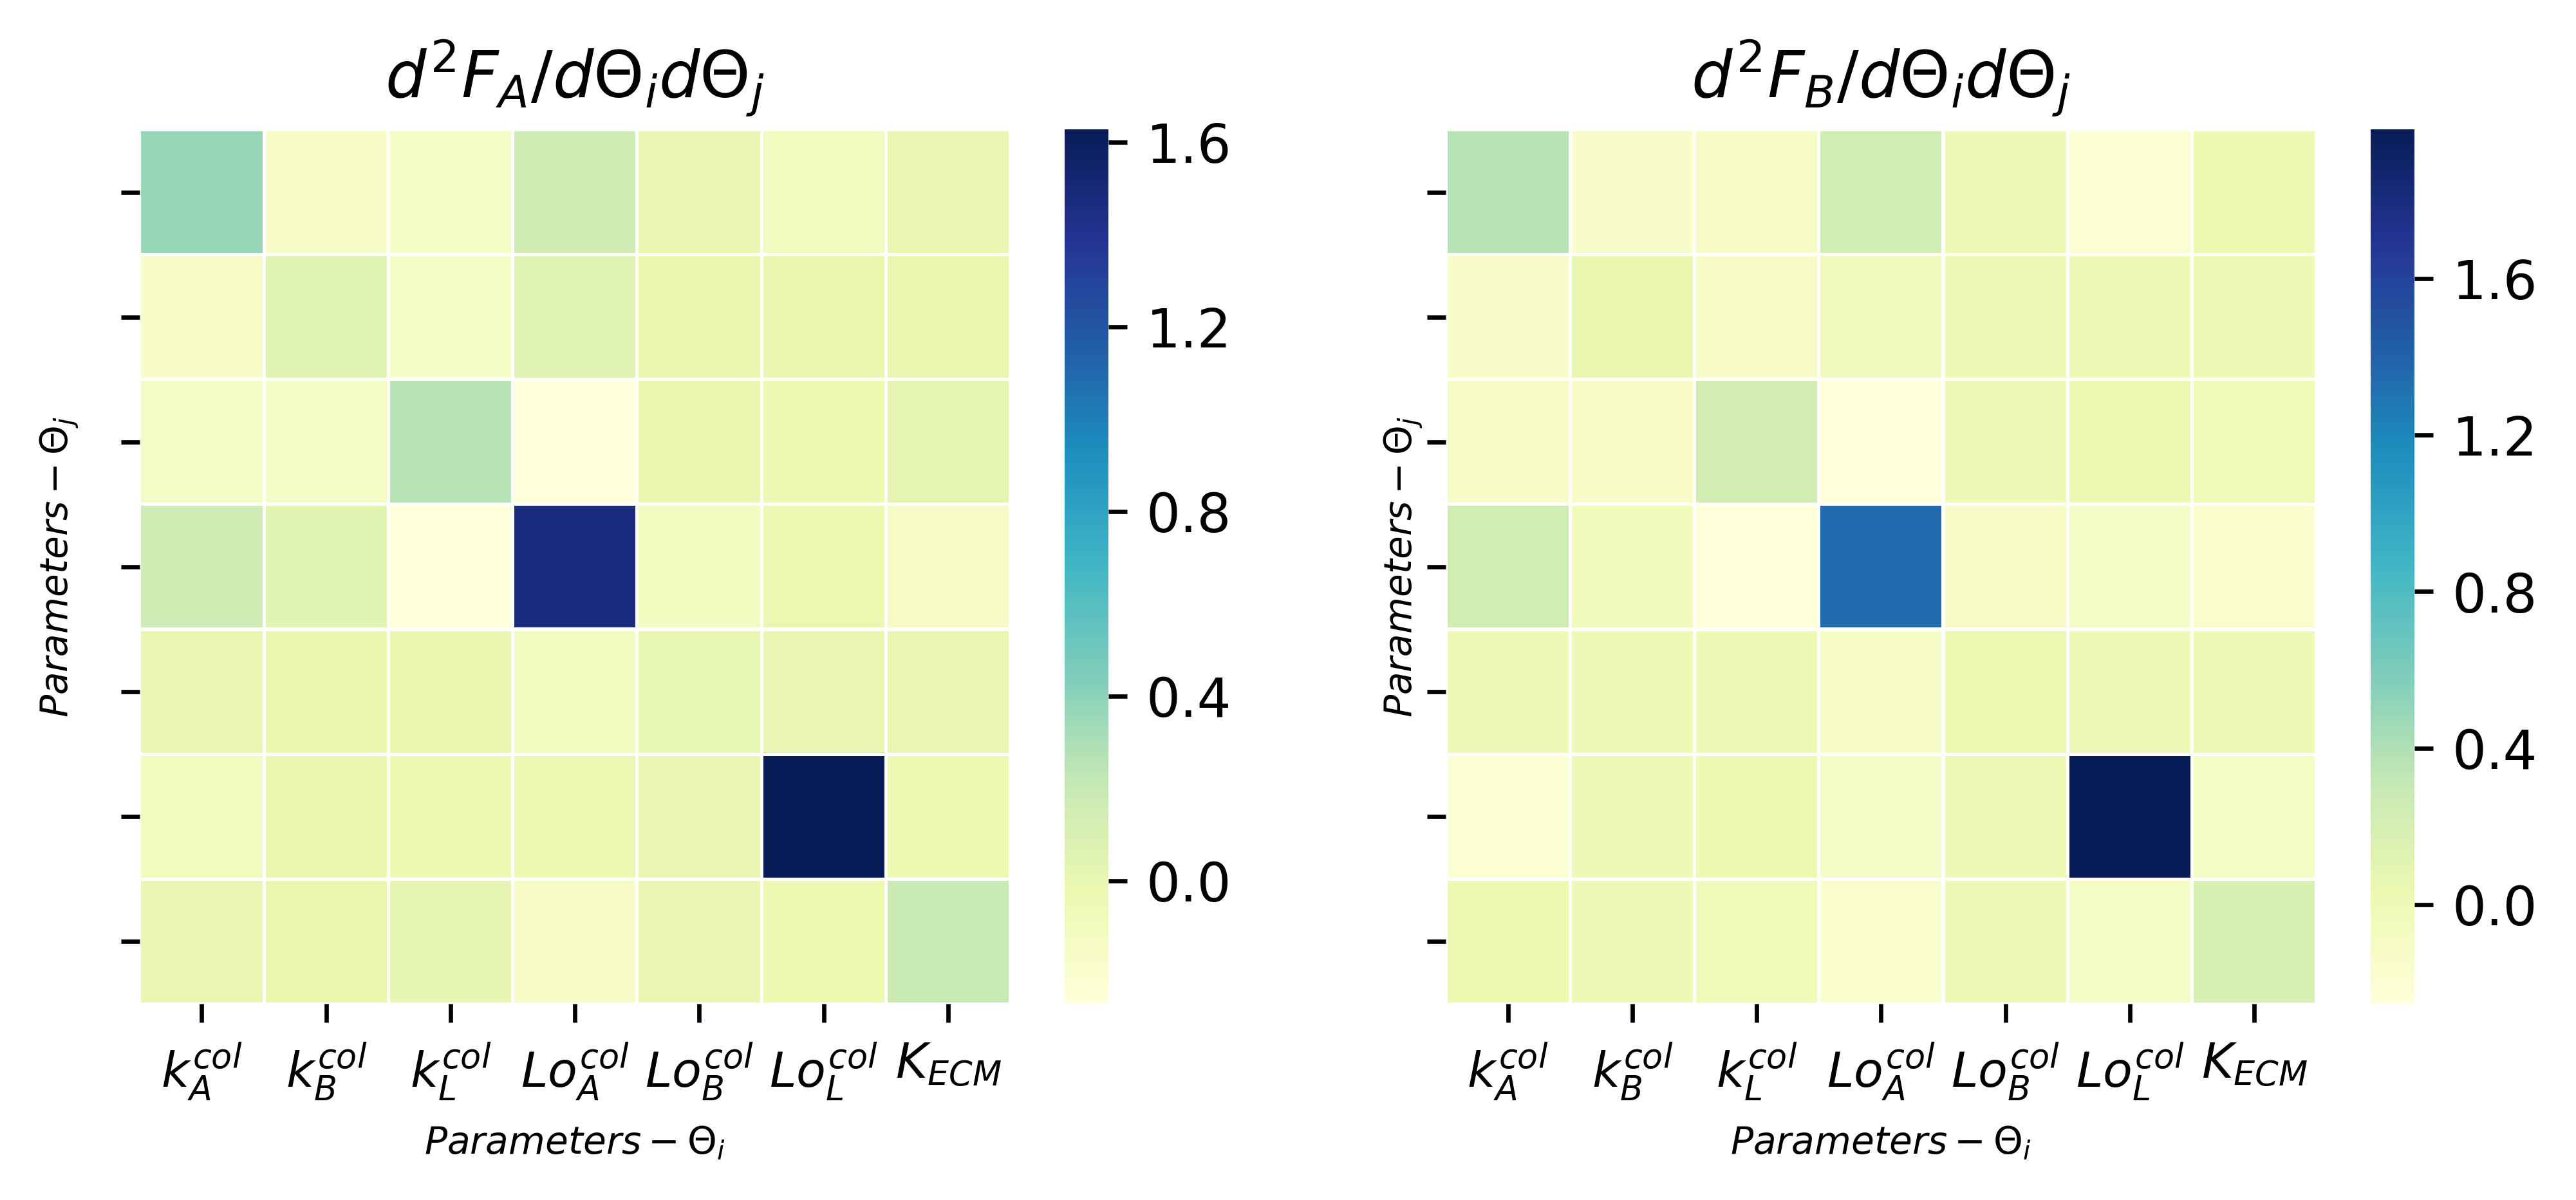

In [3]:
# Defining calculation methodologu of hessian (1: exact, 2: Percentage change)
calc_method = 2

# Totalnuber of model parameters varied
num_param = 7
# Labels of the parameters varied
params_lhs = ('$k^{col}_{A}$','$k^{col}_{B}$','$k^{col}_{L}$','$Lo^{col}_{A}$','$Lo^{col}_{B}$','$Lo^{col}_{L}$','$K_{ECM}$')
# Value of parameters for the equilibrium case
param_val = [0.01, 0.00003981, 0.01, 0.2, 0.1, 3, 0.002511886]

# Initializing hessian matrices for the apical and basal frechet errors
hessian_f_a = np.zeros((num_param,num_param))
hessian_f_b = np.zeros((num_param,num_param))

""" Part 1: Calculating non-diagonal elements"""
# Initializing the counter
k = 0
# Looping over all the parameter values
for i in range(num_param-1):
    # Interating from the parameter index ahead of the parameter index listed in previous loop to end
    for j in range(i+1,num_param):
        # Calculating the denominator of hessian tern based on calculationmethodology
        if calc_method == 1:
            di_dj = (0.7*param_val[i])*(0.7*param_val[j])
        elif calc_method == 2:
            di_dj = 0.7*0.7
        # Calculation of hessain for apical surface
        # The 1st and 2nd term of frechet errors arrays impoted are cases where both parameter value srae increased or decreased
        # The 3rd and 4th term of frechet errors arrays impoted are cases where one parameter increases and other decreases
        hessian_f_a[i,j] = (error_target_sampled_apical[4*k] + error_target_sampled_apical[4*k+1] - error_target_sampled_apical[4*k+2] - error_target_sampled_apical[4*k+3])/(4*di_dj)
        # Hessian is symmetric
        hessian_f_a[j,i] = hessian_f_a[i,j]
        # Similar methodologu of calculation of hessian for basal surface
        hessian_f_b[i,j] = (error_target_sampled_basal[4*k] + error_target_sampled_basal[4*k+1] - error_target_sampled_basal[4*k+2] - error_target_sampled_basal[4*k+3])/(4*di_dj)
        hessian_f_b[j,i] = hessian_f_b[i,j]
        # Increasing the iteration counter
        k = k + 1

""" Part 2: Calculating diagonal elements"""
# Iterating over the parameter values
for i in range(num_param):
    # Calculating the denominator of hessian tern based on calculationmethodology
    if calc_method == 1:
        di_2 = (0.7*param_val[i])*(0.7*param_val[i])
    elif calc_method == 2:
        di_2 = 0.7*0.7
    # Calculating hessian (diagonal
    hessian_f_a[i,i] = (error_apical_one_d[2*i] + error_apical_one_d[2*i+1])/di_2
    hessian_f_b[i,i] = (error_basal_one_d[2*i] + error_basal_one_d[2*i+1])/di_2
    
""" Part 3: Plotting hessian matrices as heatmaps"""        
import seaborn as sns
# Creating a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True, dpi=600)

# Subplot 1: Using seaborn to create heatmap of hessian for frechet error calaculated on apical surface
hmap1 = sns.heatmap((hessian_f_a), xticklabels = params_lhs, yticklabels = params_lhs, linewidths=.5, cmap="YlGnBu", ax=axes[0])
# Setting fontsize of x tick labels
axes[0].set_xticklabels(axes[0].get_xmajorticklabels(), fontsize = 9)
# Setting fontsize of y tick labels
axes[0].set_yticklabels(axes[0].get_ymajorticklabels(), fontsize = 9)
# Setting y axis label
axes[0].set_ylabel('$Parameters - \Theta_j$', fontsize=7)
# Setting x axis label
axes[0].set_xlabel('$Parameters - \Theta_i$', fontsize=7)
# subplot title
axes[0].set_title('$d^{2}F_{A}/d\Theta_{i}d\Theta_{j}$')

# Subplot 2: Using seaborn to create heatmap of hessian for frechet error calaculated on basal surface
hmap2 = sns.heatmap((hessian_f_b), xticklabels = params_lhs, yticklabels = params_lhs, linewidths=.5, cmap="YlGnBu", ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xmajorticklabels(), fontsize = 9)
axes[1].set_yticklabels(axes[1].get_ymajorticklabels(), fontsize = 9)
axes[1].set_ylabel('$Parameters - \Theta_j$', fontsize=7)
axes[1].set_xlabel('$Parameters - \Theta_i$', fontsize=7)
axes[1].set_title('$d^{2}F_{B}/d\Theta_{i}d\Theta_{j}$')

## 3. Computing eigenvalues and eigenvectors for hessian

- Eigenvalue and Eigenvector of the hessian corresponding to frechet error of apical and basal surfaces are calculated
- Eigenvectors corresponding to the dominant eigenvalues are analyszed

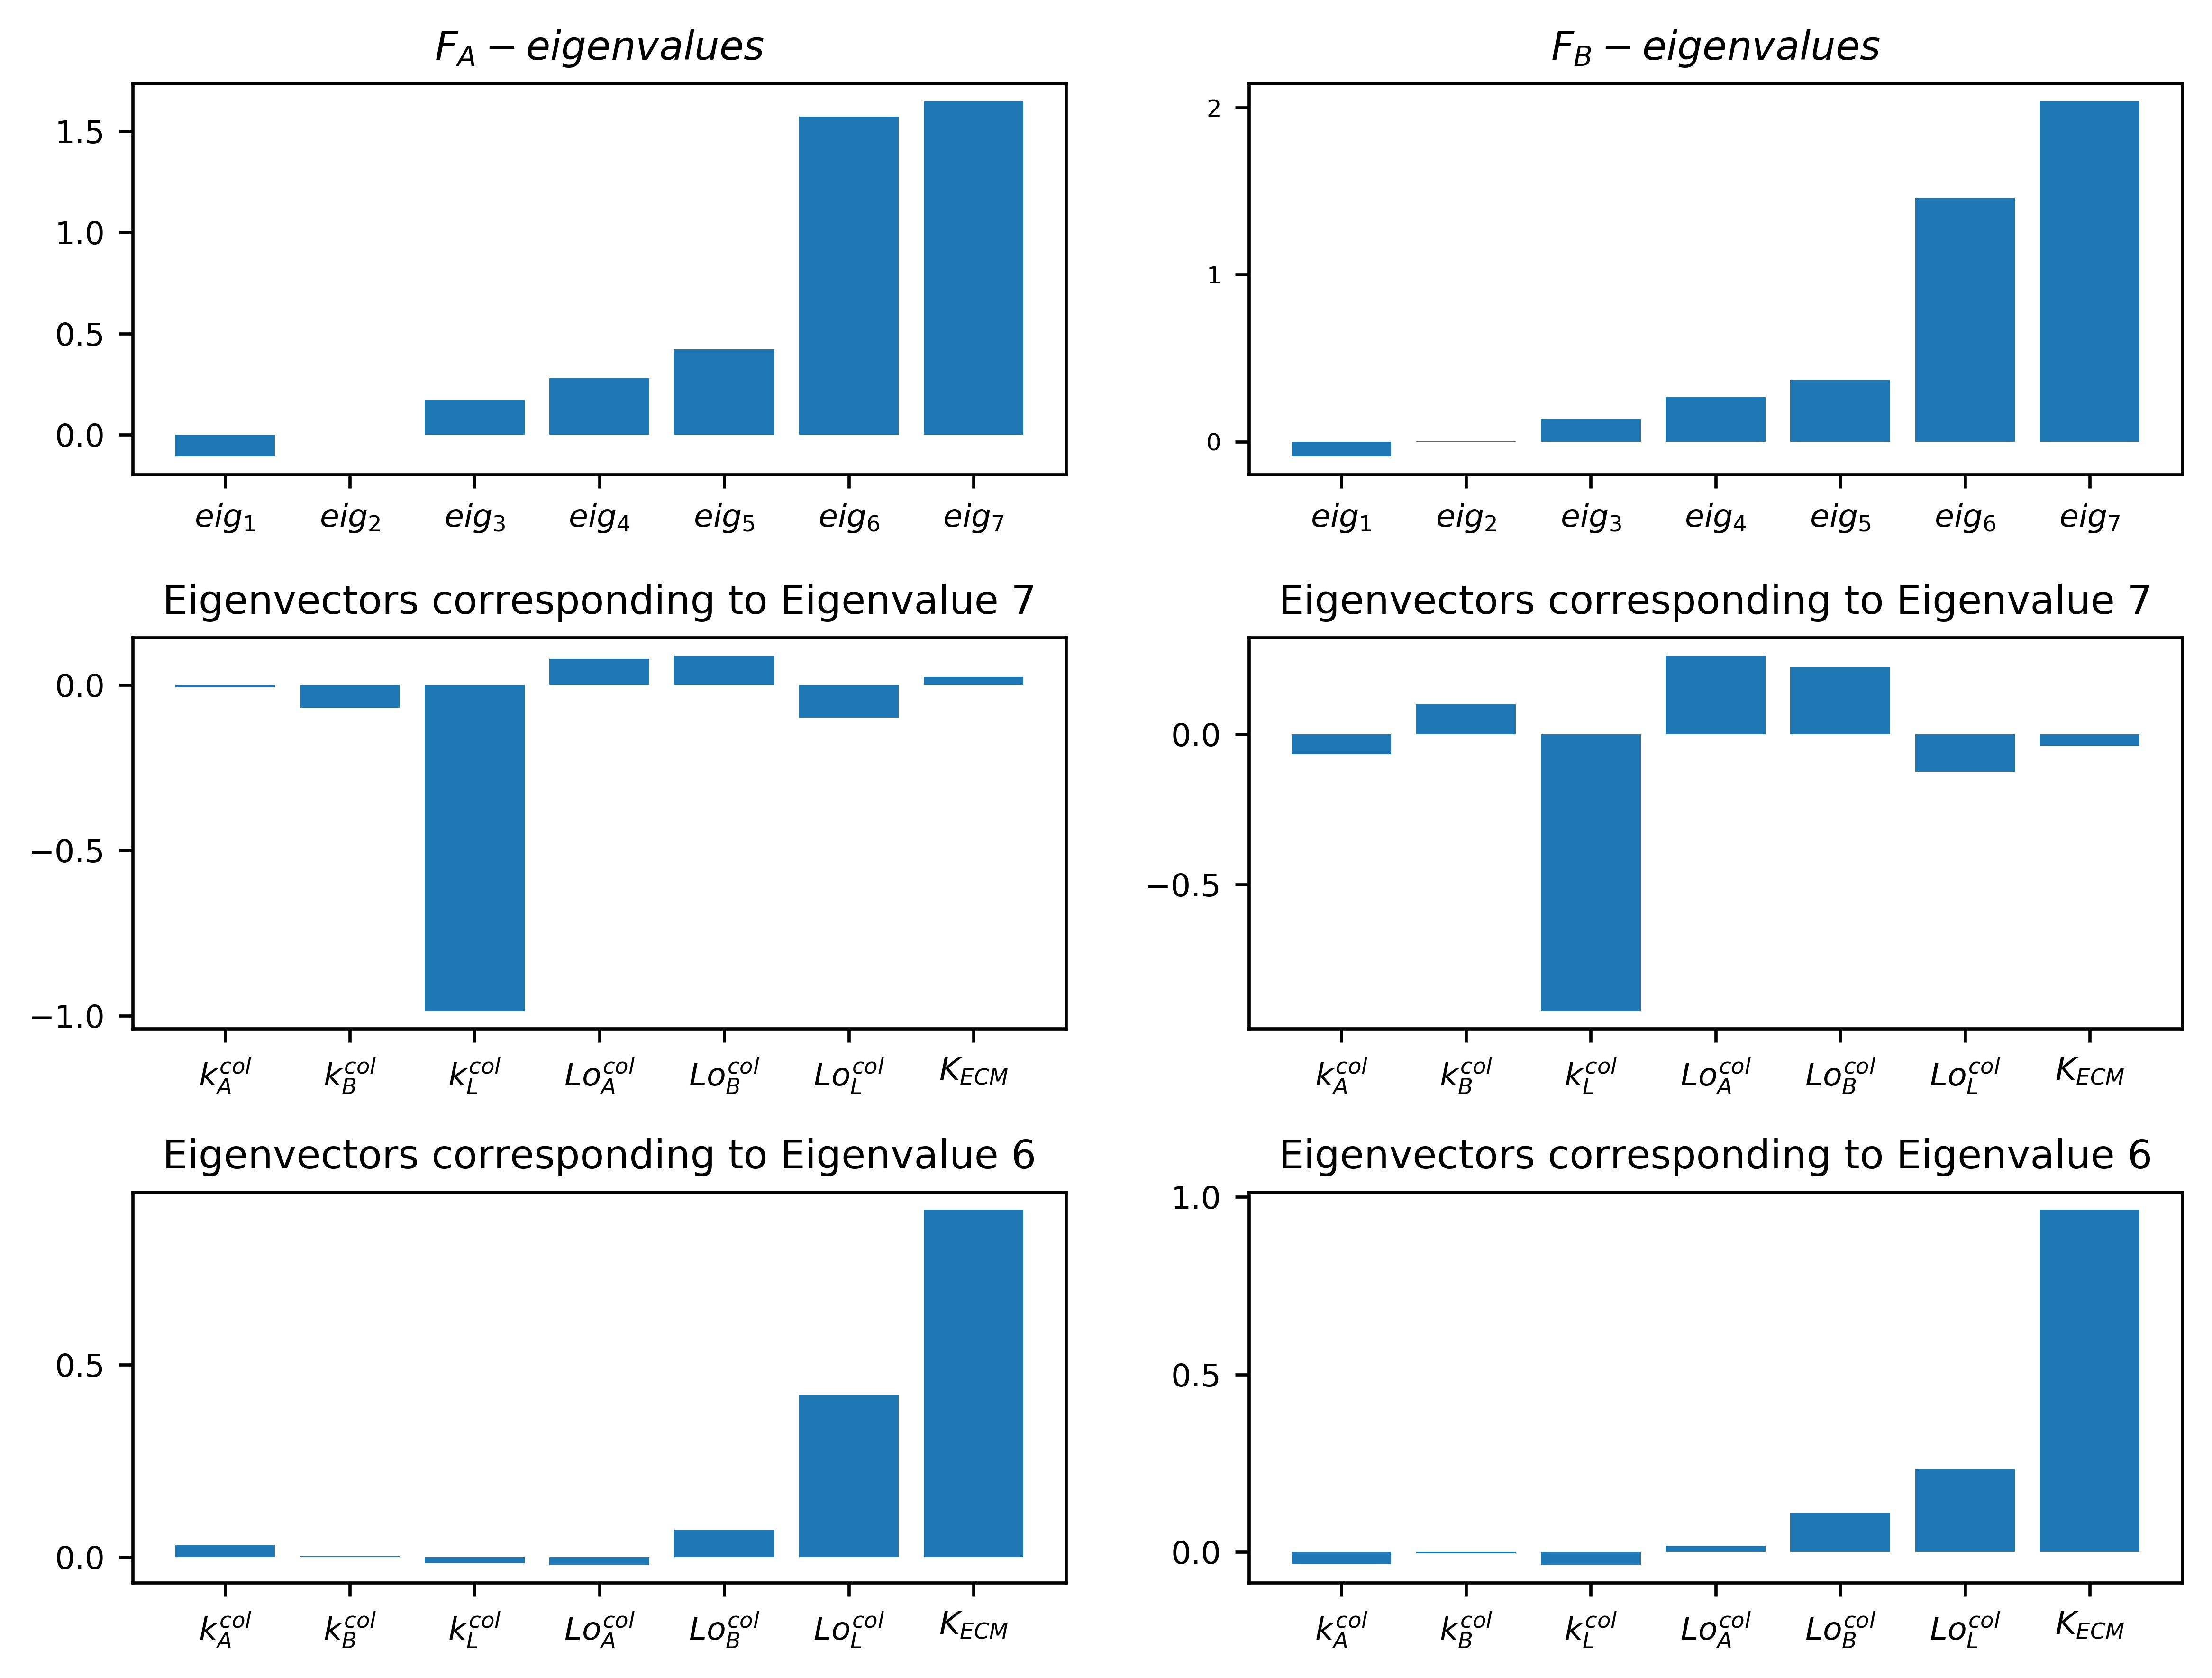

In [4]:
# Calculating eigenvalue and eigenvector of hessian matrix correspondig to frechet error of apical surface 
# np.linalg.eigh is used as the matrix is symmetric
hess_eval_fa, hess_evec_fa = np.linalg.eigh(hessian_f_a)
# Calculating eigenvalue and eigenvector of hessian matrix correspondig to frechet error of basal surface 
hess_eval_fb, hess_evec_fb = np.linalg.eigh(hessian_f_b)

""" Plotting eigenvalues and eigenvectors"""
# Defining figure size and subplot details
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(8, 6), dpi=600)
# Defining labels of sorted eigenvalues
eig_labels = ('$eig_{1}$', '$eig_{2}$', '$eig_{3}$', '$eig_{4}$', '$eig_{5}$', '$eig_{6}$', '$eig_{7}$')
# Creating position on x axis for placing the bars
y_pos = np.arange(len(eig_labels))

""" Step I: Plotting the eigenvalues as barplot"""
# Plotting eigenvalues corresponding to hessian of frechet apical error
plt.subplot(3, 2, 1)
# Plotting eigenvales as bars
plt.bar(y_pos,hess_eval_fa)
# Defining fontsize
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# Defining labels of x axis
plt.xticks(y_pos, eig_labels)
# Defining title of plot
plt.title('$F_{A} - eigenvalues$', fontsize=10)
# Plotting eigenvalues corresponding to hessian of frechet basal error
plt.subplot(3, 2, 2)
plt.bar(y_pos,hess_eval_fb)
plt.xticks(fontsize=8)
plt.yticks(fontsize=6)
plt.xticks(y_pos, eig_labels)
plt.title('$F_{B} - eigenvalues$', fontsize=10)

""" Step 2: Plotting the eigenvectors corresponding to the largest eigenvalues"""
# Counter for subplot
k = 3
# Accessing eigenvectors corresponding to two greatest eigenvalues
for i in range(2):
    # Plotting eigenvector corresponding to  i+1th largest eigenvalue of apical frechet error
    plt.subplot(3, 2, k)
    plt.bar(y_pos,hess_evec_fa[6-i,:])
    # Defining fontsize
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    # Defining labels of x axis
    plt.xticks(y_pos, params_lhs)
    # Defining title of plot
    plt.title('Eigenvectors corresponding to Eigenvalue ' + str(7-i), fontsize=10)
    # Increasing counter of the subplot
    k = k + 1
    # Plotting eigenvector corresponding to  i+1th largest eigenvalue of basal frechet error
    plt.subplot(3, 2, k)
    plt.bar(y_pos,hess_evec_fb[6-i,:])
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xticks(y_pos, params_lhs)
    plt.title('Eigenvectors corresponding to Eigenvalue ' + str(7-i), fontsize=10)
    k = k + 1

# Adjusting spacing between subplots
fig.tight_layout()
    
    